In [1]:
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile
import numpy as np
import pandas as pd
from matplotlib.colors import LogNorm
import glob
import os

c:\Users\kolea\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [8]:
# Folder containing the text files
folder_path = "data/Samples Grey Seal/Rupes A and B/"

# Initialize an empty list to store DataFrames
dataframes = []

# Get all .txt files in the folder
txt_files = glob.glob(os.path.join(folder_path, "*.txt"))

# Iterate through each text file
for txt_file in txt_files:
    # Get the base name of the corresponding .wav file
    base_name = os.path.splitext(os.path.basename(txt_file))[0].replace(".Table.1.selections", "")
    wav_file = f"{base_name}.wav"  # Name of the associated .wav file

    # Load the text file into a DataFrame
    df = pd.read_csv(txt_file, sep='\t', header='infer')

    # Add a column for the corresponding .wav file
    df['Audio File'] = wav_file

    # Append the DataFrame to the list
    dataframes.append(df)

# Combine all DataFrames into one
combined_df = pd.concat(dataframes, ignore_index=True)

# Display the combined DataFrame
combined_df.head()

# Save the combined DataFrame to a CSV file for reference
combined_df.to_csv(os.path.join("data/combined_calls.csv"), index=False)


In [10]:
#look at full dataframe for every call
combined_df

,Selection,View,Channel,Begin Time (s),End Time (s),Low Freq (Hz),High Freq (Hz),Delta Time (s),Delta Freq (Hz),Avg Power Density (dB FS/Hz),Annotation,Audio File
0,1,Spectrogram 1,1,13.433865,13.703649,53.191,324.361,0.2698,271.170,-79.66,Rupe B,5713.210806110002.wav
1,2,Spectrogram 1,1,26.072555,26.283886,53.191,376.259,0.2113,323.068,-84.94,Rupe B,5713.210806110002.wav
2,3,Spectrogram 1,1,53.382769,53.528888,66.489,478.723,0.1461,412.234,-89.26,Rupe A,5713.210806110002.wav
3,4,Spectrogram 1,1,65.997665,66.110075,59.347,415.430,0.1124,356.083,-86.86,Rupe A,5713.210806110002.wav
4,5,Spectrogram 1,1,81.003161,81.266117,59.347,376.259,0.2630,316.912,-82.32,Rupe B,5713.210806110002.wav
...,...,...,...,...,...,...,...,...,...,...,...,...
502,123,Spectrogram 1,1,1133.598158,1134.392678,76.923,346.154,0.7945,269.231,-95.60,Guttural rupe,5713.210908180002.wav
503,124,Spectrogram 1,1,1156.237917,1156.973077,115.385,365.014,0.7352,249.629,-94.13,Guttural rupe,5713.210908180002.wav
504,125,Spectrogram 1,1,1189.129105,1189.343717,61.983,413.223,0.2146,351.240,-99.62,Rupe A,5713.210908180002.wav
505,126,Spectrogram 1,1,1190.558354,1190.731845,68.871,365.014,0.1735,296.143,-98.27,Type 4 A,5713.210908180002.wav


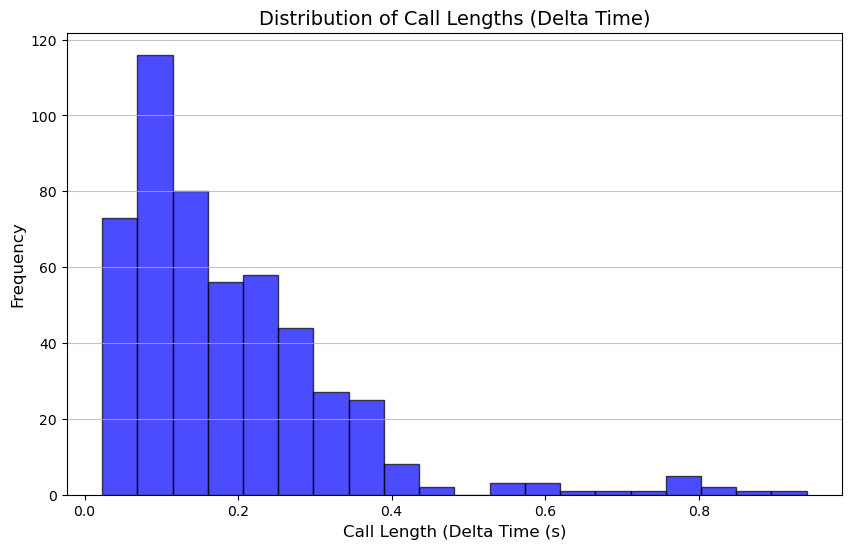

In [12]:
# PLot the distribution of call durations

# Plot the distribution of Delta Time (s)
plt.figure(figsize=(10, 6))
plt.hist(combined_df['Delta Time (s)'], bins=20, color='blue', edgecolor='black', alpha=0.7)
plt.title("Distribution of Call Lengths (Delta Time)", fontsize=14)
plt.xlabel("Call Length (Delta Time (s)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(axis='y', alpha=0.75)
plt.show()

In [17]:
# Check what calls are included and how many of each

unique_calls = combined_df['Annotation'].value_counts(sort=False)
unique_calls

Annotation
Rupe B           121
Rupe A           342
Type 4 A          12
Rupe C             8
Growl B            2
G rupe             5
unidentified       1
Trrot              4
Unidentified       1
??                 2
?                  2
Guttural rupe      7
Name: count, dtype: int64

Some of the calls were un-identified or were identified as Trrot or Type 4 A. I am unsure what type of call this is. However they are in low number and will be excluded from our project going forward. 

In [20]:
#List of Annotation types that we want to keep

annotations_to_include = ['Rupe A', 'Rupe B', 'Rupe C', 'Growl B', 'Guttural rupe']
filtered_df = combined_df[combined_df['Annotation'].isin(annotations_to_include)]

filtered_df['Annotation'].value_counts(sort=False)


Annotation
Rupe B           121
Rupe A           342
Rupe C             8
Growl B            2
Guttural rupe      7
Name: count, dtype: int64

In [13]:
# Iterate through each row in the combined DataFrame
for index, row in combined_df.iterrows():
    # Get the associated audio file
    audio_path = os.path.join(folder_path, row['Audio File'])

    # Load the audio file
    if not os.path.exists(audio_path):
        print(f"Audio file {audio_path} not found. Skipping...")
        continue

    sample_rate, samples = wavfile.read(audio_path)

    # Calculate the midpoint of the call
    call_midpoint = (row['Begin Time (s)'] + row['End Time (s)']) / 2

    # Define the 3-second time window around the call
    time_start = call_midpoint - 1.5
    time_end = call_midpoint + 1.5

    # Convert time to sample indices
    start_sample = int(time_start * sample_rate)
    end_sample = int(time_end * sample_rate)

    # Handle edge cases where the segment exceeds the audio boundaries
    if start_sample < 0:
        start_sample = 0
    if end_sample > len(samples):
        end_sample = len(samples)

    # Extract the audio segment
    segment = samples[start_sample:end_sample]

    # Compute the spectrogram for the segment
    frequencies, times, spectrogram = signal.spectrogram(
        segment, sample_rate, nperseg=1024, nfft=2048, noverlap=512, window='hann'
    )

    # Adjust times to reflect the original audio time range
    times = times + time_start  # Shift the spectrogram time axis to match the original audio timestamps

    # Save the spectrogram data as a .npz file
    output_file = os.path.join(f"data/processed/Spectrograms/{row['Audio File']}_call_{index + 1}_{row['Annotation'].replace(' ', '_')}.npz")
    np.savez_compressed(
        output_file,
        spectrogram=spectrogram,
        frequencies=frequencies,
        times=times,
        annotation=row['Annotation'],
        time_start=time_start,
        time_end=time_end
    )

    print(f"Processed call {index + 1} from {row['Audio File']} and saved as .npz.")

Processed call 1 from 5713.210806110002.wav and saved as .npz.
Processed call 2 from 5713.210806110002.wav and saved as .npz.
Processed call 3 from 5713.210806110002.wav and saved as .npz.
Processed call 4 from 5713.210806110002.wav and saved as .npz.
Processed call 5 from 5713.210806110002.wav and saved as .npz.
Processed call 6 from 5713.210806110002.wav and saved as .npz.
Processed call 7 from 5713.210806110002.wav and saved as .npz.
Processed call 8 from 5713.210806110002.wav and saved as .npz.
Processed call 9 from 5713.210806110002.wav and saved as .npz.
Processed call 10 from 5713.210806110002.wav and saved as .npz.
Processed call 11 from 5713.210806110002.wav and saved as .npz.
Processed call 12 from 5713.210806110002.wav and saved as .npz.
Processed call 13 from 5713.210806110002.wav and saved as .npz.
Processed call 14 from 5713.210806110002.wav and saved as .npz.
Processed call 15 from 5713.210806110002.wav and saved as .npz.
Processed call 16 from 5713.210806110002.wav and 

OSError: [Errno 22] Invalid argument: 'data/processed/Spectrograms/5713.210827200002.wav_call_377_??.npz'

In [ ]:
folder_path = "data/Samples Grey Seal/Rupes A and B"

# Get all .wav files in the folder
audio_files = glob.glob(os.path.join(folder_path, "*.wav"))


file = "data/Samples Grey Seal/Rupes A and B/5713.210806110002"
audio_path = f'{file}.wav'
txt_path = f'{file}.Table.1.selections.txt'

# Load the audio file
sample_rate, samples = wavfile.read(audio_path)

# Step 2: Load the text file into a DataFrame
calls_df = pd.read_csv(txt_path, sep='\t', header='infer')
calls_df

,Selection,View,Channel,Begin Time (s),End Time (s),Low Freq (Hz),High Freq (Hz),Delta Time (s),Delta Freq (Hz),Avg Power Density (dB FS/Hz),Annotation
0,1,Spectrogram 1,1,13.433865,13.703649,53.191,324.361,0.2698,271.170,-79.66,Rupe B
1,2,Spectrogram 1,1,26.072555,26.283886,53.191,376.259,0.2113,323.068,-84.94,Rupe B
2,3,Spectrogram 1,1,53.382769,53.528888,66.489,478.723,0.1461,412.234,-89.26,Rupe A
3,4,Spectrogram 1,1,65.997665,66.110075,59.347,415.430,0.1124,356.083,-86.86,Rupe A
4,5,Spectrogram 1,1,81.003161,81.266117,59.347,376.259,0.2630,316.912,-82.32,Rupe B
...,...,...,...,...,...,...,...,...,...,...,...
135,136,Spectrogram 1,1,1195.338696,1195.635973,45.147,316.027,0.2973,270.880,-82.30,Rupe B
136,137,Spectrogram 1,1,96.013998,96.202847,73.522,363.284,0.1888,289.762,-89.37,Rupe A
137,138,Spectrogram 1,1,116.156708,116.207579,67.278,241.590,0.0509,174.312,-87.09,Rupe A
138,139,Spectrogram 1,1,705.182751,705.284493,76.500,297.729,0.1017,221.229,-90.90,Rupe A


In [3]:
# Define colors for annotations
annotation_colors = {
    "Rupe A": "red",
    "Rupe B": "green",
    "Growl B": "yellow",
    "Rupe C": "purple",
    "Moan": "pink",
    "G rupe": "blue"
}

In [4]:
# Function to extract a centered 3-second audio segment
def extract_centered_segment(start_time, end_time, samples, sample_rate, segment_length=3.0):
    call_midpoint = (start_time + end_time) / 2  # Calculate the midpoint of the call

    # starting 1.5 secnods before the call midpoint
    segment_start_time = call_midpoint - segment_length / 2
    # ending 1.5 secnods after the call midpoint
    segment_end_time = call_midpoint + segment_length / 2

    # Convert time to sample indices
    start_sample = int(segment_start_time * sample_rate)
    end_sample = int(segment_end_time * sample_rate)

    # Handle edge cases: if the window goes outside the audio range
    if start_sample < 0:
        padding_start = abs(start_sample)
        start_sample = 0
    else:
        padding_start = 0

    if end_sample > len(samples):
        padding_end = end_sample - len(samples)
        end_sample = len(samples)
    else:
        padding_end = 0

    # Extract the segment and pad with zeros if necessary
    segment = samples[start_sample:end_sample]
    if padding_start > 0 or padding_end > 0:
        segment = np.pad(segment, (padding_start, padding_end), mode='constant')
    
    return segment

# Function to overlay annotations
def overlay_annotations(ax, row, annotation_colors):
    # Extract annotation details
    start_time = 1.5  # Call is always centered at 1.5 seconds in the 3-second segment
    end_time = 1.5 + (row['End Time (s)'] - row['Begin Time (s)'])
    low_freq = row['Low Freq (Hz)']
    high_freq = row['High Freq (Hz)']
    annotation = row['Annotation']

    # Skip if the annotation is not in the defined colors
    if annotation not in annotation_colors:
        return

    # Add a rectangle to the plot
    rect = Rectangle(
        (start_time, low_freq),  # Bottom-left corner
        end_time - start_time,  # Width (duration of the call)
        high_freq - low_freq,  # Height (frequency range of the call)
        edgecolor=annotation_colors[annotation],
        facecolor='none',
        linewidth=2,
        label=annotation
    )
    ax.add_patch(rect)

In [5]:
for index, row in calls_df.iterrows():
    # Calculate the midpoint of the call
    call_midpoint = (row['Begin Time (s)'] + row['End Time (s)']) / 2

    # Define the 3-second time window around the call
    time_start = call_midpoint - 1.5
    time_end = call_midpoint + 1.5

    # Convert time to sample indices
    start_sample = int(time_start * sample_rate)
    end_sample = int(time_end * sample_rate)

    # Handle edge cases where the segment exceeds the audio boundaries
    if start_sample < 0:
        start_sample = 0
    if end_sample > len(samples):
        end_sample = len(samples)

    # Extract the audio segment
    segment = samples[start_sample:end_sample]

    # Compute the spectrogram for the segment
    frequencies, times, spectrogram = signal.spectrogram(
        segment, sample_rate, nperseg=1024, nfft=2048, noverlap=512, window='hann'
    )

    # Adjust times to reflect the original audio time range
    times = times + time_start  # Shift the spectrogram time axis to match the original audio timestamps

    # Trim the spectrogram frequencies to the desired range (20 Hz to 1000 Hz)
    freq_start, freq_end = 20, 700  # Frequency range in Hz
    freq_indices = np.where((frequencies >= freq_start) & (frequencies <= freq_end))[0]
    frequencies = frequencies[freq_indices]
    spectrogram = spectrogram[freq_indices, :]

    # Plot the spectrogram
    plt.figure(figsize=(10, 6))
    pc = plt.pcolormesh(times, frequencies, spectrogram, norm=LogNorm(), cmap='Spectral_r')
    cbar = plt.colorbar(pc)
    cbar.set_label('Power [dB]')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [s]')
    plt.title(f"Spectrogram for Call {index + 1} ({row['Annotation']})")

    annotation_cleaned = row['Annotation'].replace(" ", "_")

    # Save the spectrogram as an image
    plt.tight_layout()
    plt.savefig(f'data/processed/Spectrograms/spectrogram_call_{index + 1}_{annotation_cleaned}.png')
    plt.close()

print("Spectrograms generated for all calls.")

Spectrograms generated for all calls.
